## Linear Regression
#### 背景：
线性回归是一种源自统计学的经典机器学习预测模型，它有解析求解和梯度下降优化两种解法，
使用梯度下降优化的线性回归模型也是后续逻辑回归模型和深度学习全连网络实现的基石。

#### 目的：
1. 借助线性回归模型，探究主要数据预处理方法作用，及其对模型结果的影响
2. 探究矩阵运算对模型计算效率的提升作用
3. 探究模型过拟合的抑制方法和实用策略


In [44]:
# 环境初始化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 执行全部行输出命令

### 数据准备
浏览数据集描述信息后发现：
1. 数据集一共有13个特征、506个样本，且数据集中没有缺失数据；
2. 13个特征中，数值型特征11个，类别型特征2个（CHAS,RAD）

In [45]:
# 加载数据
from sklearn.datasets import load_boston
data = load_boston()
print(data['DESCR'])
# data

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [46]:
# 数据集特征探索
df = pd.DataFrame(data['data'],columns=data['feature_names'])
df['target']=data['target']
df.info(); df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 数据预处理
1. 数值型特征与类别型特征分离
2. 缺失值填充
3. 重复值处理
4. 异常值检测
5. 类别型特征编码
6. 数值型特征转换
7. 特征衍生与降维（可选）
8. 特征筛选（慎重）
9. 数据集分割

In [47]:
# 数值型特征与类别型特征分离
df_cat = df[['CHAS','RAD']].astype('int').astype('category')
df_num = df.drop(columns=['CHAS','RAD','target'])
# print(df_cat.shape); print(df_num.shape)
df.dropna()

#### 类别型特征编码主要有 ordinal encoding 和 one-hot encoding 两种方法

1. ordinal encoding编码
适用于处理类别间具有大小关系的顺序型类别特征，它按类别大小关系，给其赋予一个从1到n的正整数数值ID，将类别型特征转化成数值型哑变量。

2. one-hot encoding
适用于处理类别间不具有大小关系的分类型类别特征，它按特征值类别数量产生一个n维0-1稀疏向量，每种特征值由向量中对应维度为1、其它维度为0表示。
**使得任意两不同类别的编码向量之差相等，使得模型学习时，可以对每种类别一直同仁。**

3. 网传可以通过二进制编码的方法，转化分类型类别特征，得到与one-hot encoding同样的效果，并且向量维数少于one-hot、节省存储空间。
**这种说法是完全不对的，因为二进制编码与ordinal encoding的本质相同：编码向量间存在大小关系，任意不同类别编码向量间差值不等，模型学习时不能对特征的每种类别一视同仁**

In [48]:
# 类别型特征编码
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
nar_cat = onehot.fit_transform(df_cat).toarray()


In [49]:
# 数值型特征描述性统计分析
df_num.describe()


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000


#### 数值型特征转换主要有Feature Scaling和Non-linear transformation两大类方法

**Feature Scaling**

标准化

定义：对不同维度数值特征做线性变换，使得不同度量之间的特征具有可比性，它不改变原始数据的分布。

常用方法：
1. Normalization (min-max normalization)
2. Standardization(Z-score normalization)

Normalization是一个源于统计学的概念，它包含数据预处理中常说的Standardization和Normalization两个概念，它们都是Feature Scaling的一种方法。

*特别注意的是，稀疏数据一般不要执行标准化转换，因为Normalization会将一个多数元素为0的稀疏向量转化成一个多数元素不为0的密集特征向量，这会给模型运算带来巨大的负担。*

**Non-linear transformation**

归一化

定义：对不同维度数值特征做非线性变换，使各个特征维度对目标函数的影响权重一致，即将那些扁平分布的特征数据伸缩变换成类圆形分布，会改变原始数据的分布。

常用方法：
1. L2范数归一化
2. 对数变换
3. 指数变换

In [50]:
# 数值型特征缩放
from sklearn.preprocessing import StandardScaler
standardized = StandardScaler()
nar_num = standardized.fit_transform(df_num)

#### 特征筛选

In [51]:
# 特征线性相关性筛选
col_cat = ['CHAS'+str(i) for i in df_cat.CHAS.drop_duplicates()]+['RAD'+str(i) for i in df_cat.RAD.drop_duplicates()]
col_num = list(df_num.columns)
col = col_num + col_cat + ['target']
df_rul = pd.DataFrame(np.concatenate((nar_num, nar_cat, df[['target']].values), axis=1), columns=col)
df_rul.corr()['target'].sort_values(ascending=False)

# 获取标签数据集
y = df_rul[['target']].values.reshape(len(data['target']),1)

# 获取特征数据集1：保留全部特征
X_all = df_rul.drop(columns='target').values

# 获取特征数据集2：去除低相关性特征，保留中、高相关性特征
X_lcM = np.concatenate((nar_num, df_rul[['RAD24']].values), axis=1)

# 获取特征数据集3：仅保留高相关性特征
X_lcH = df_rul[['RM','PTRATIO','LSTAT']].values


target     1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
RAD7       0.190053
RAD4       0.187356
CHAS1      0.175260
RAD3       0.167352
RAD2       0.104444
RAD6       0.092802
RAD1       0.040453
RAD8      -0.039411
RAD5      -0.065711
CHAS0     -0.175260
AGE       -0.376955
CRIM      -0.388305
RAD24     -0.396297
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: target, dtype: float64

#### 数据集分割

In [52]:
# 数据集分割
from sklearn.model_selection import train_test_split
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=0)
X_lcM_train,X_lcM_test = train_test_split(X_lcM, test_size=0.2, random_state=0)
X_lcH_train,X_lcH_test = train_test_split(X_lcH, test_size=0.2, random_state=0)
# np.random.seed(42)
# def data_split(data, test_ratio=0.2, val_ratio=0, index=0):
#     if isinstance(index,int): index = np.random.choice(range(len(data)), size=len(data), replace=False)
#     train_index = index[:int(len(data)*(1-val_ratio-test_ratio))]
#     val_index = index[int(len(data)*(1-val_ratio-test_ratio)):int(len(data)*(1-test_ratio))]
#     test_index = index[int(len(data)*(1-test_ratio)):]
#     return data[train_index], data[test_index], data[val_index], index
# #
# y_train,y_test,_,_ = data_split(y,test_ratio=0.2)
# X_all_train,X_all_test,_,X_index = data_split(X_all,test_ratio=0.2)
# X_lcM_train,X_lcM_test,_,_ = data_split(X_lcM,test_ratio=0.2,index=X_index)
# X_lcH_train,X_lcH_test,_,_ = data_split(X_lcH,test_ratio=0.2,index=X_index)


In [53]:
# 模型定义
def LinReg_train(X,y,num_epochs,lr,lam,patient):
    num_sample,num_feature = X.shape
    # 初始化
    W_rec = [np.random.normal(0,1,(1,num_feature))]
    b_rec = [0]
    loss = [0]              # 每迭代损失函数值记录器
    loss_diff = [np.inf]    # 每迭代损失函数下降步长记录器
    j = 0                   # patient消耗程度记录器
    # 训练
    for i in range(num_epochs):
        W = W_rec[i]; b = b_rec[i]
        y_hat = X.dot(W.T)+b
        # MSE & L2
        # ls = np.sum((y_hat-y)**2)/(2*num_sample) + (lam/2)*W.dot(W.T)
        ls = np.sum((y_hat-y)**2)/(2*num_sample)
        # ls = (y_hat-y).dot((y_hat-y).T)/(2*num_sample)
        loss.append(float(ls))
        # 提前终止
        loss_diff.append(float(abs(loss[-1]-loss[-2])))
        if loss_diff[-1]>=min(loss_diff[:-1]): j+=1
        if j==patient:
            minLoss_index = loss.index(min(loss[1:]))
            return loss[1:minLoss_index+1], W_rec[minLoss_index-1], b_rec[minLoss_index-1]
        # 优化（GradientDescent & L2）
        W = W-lr*(y_hat-y).T.dot(X)/num_sample - lr*lam*W
        b = b-lr*np.mean(y_hat-y)
        W_rec.append(W); b_rec.append(b)
    return loss[1:], W_rec[-1], b_rec[-1]

# 预测
def LinReg_price(X,y,W,b):
    num_sample,_ = X.shape
    y_hat = X.dot(W.T)+b
    # MSE
    ls = np.sum((y_hat-y)**2)/(2*num_sample)
    # ls = (y_hat-y).dot((y_hat-y).T)/(2*num_sample)
    return y_hat, ls


### 抑制过拟合
正则化和特征筛选是抑制过拟合的常用方法；

其中，正则化常用实现方法有参数L2/L1范数惩罚和提前终止等，它们可以组合使用也可以单独使用。

特征选择方法十分丰富，其目的是选出对预测标签最重要的一些特征，常用方法有线性相关性筛选、决策树/随机森林节点排序筛选和借助参数L1范数惩罚实现

基于本项目的试验结果，综合来看过拟合抑制方法的推荐排序是首先使用提前终止和参数L2范数惩罚，如果效果能不满足要求再谨慎使用特征筛选。

这是因为，提前终止没有需要校调的超参数，且在抑制过拟合的同时不会带来任何负面影响，但花无两样红，不得不说的是提前终止的过拟合抑制能力也远弱于另两种方法；

另一方面，谨慎使用特征筛选的原因是，特征筛选会损失信息，同时本项目的试验结果显示，同时使用提前终止、参数惩罚时，特征筛选会增加一些模型预测结果的不稳定性（重复执行程序，针对不同随机抽样数据，模型评估指标波动程度增加）；

通过合理设置参数L2范数惩罚项系数，可以在充分抑制过拟合的同时不损失特征信息、避免结果不稳定，所以结论：优先进行范数惩罚，最后再考虑特征筛选。


In [54]:
# 超参数定义
num_epochs =1000000 #训练迭代次数
lr = 0.03           #学习率
lam = 10            #正则化惩罚系数
patient = 10        #提前停止容忍度
Num = 100          #重复试验次数

In [55]:
#
# loss_CV,W,b = LinReg_train(X_train,y_train,num_epochs,lr,lam,patient)
# loss_CV[-1]
# 代价函数值收敛趋势图
# plt.plot(np.arange(len(loss_CV)-1), loss_CV[1:], 'r')
# plt.show()
#
# y_hat, ls = LinReg_price(X_test,y_test,W,b)
# ls

28.65079518821054

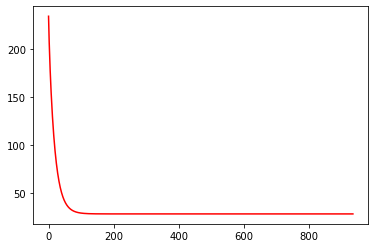

32.00608423306773

In [56]:
# 全特征
loss_CV,W,b = LinReg_train(X_all_train,y_train,num_epochs,lr,lam,patient)
loss_CV[-1]
plt.plot(np.arange(len(loss_CV)-1), loss_CV[1:], 'r')
plt.show()
#
y_hat, ls = LinReg_price(X_all_test,y_test,W,b)
ls

28.740420512140155

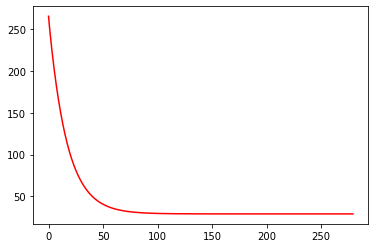

32.04457286652853

In [57]:
# 中相关特征
loss_CV,W,b = LinReg_train(X_lcM_train,y_train,num_epochs,lr,lam,patient)
loss_CV[-1]
# 代价函数值收敛趋势图
plt.plot(np.arange(len(loss_CV)-1), loss_CV[1:], 'r')
plt.show()
#
y_hat, ls = LinReg_price(X_lcM_test,y_test,W,b)
ls

33.36319512651856

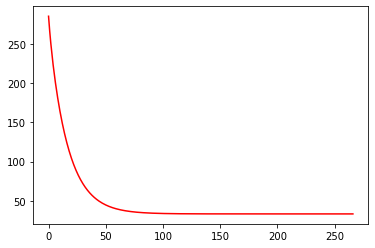

33.929421228710126

In [58]:
# 高相关特征
loss_CV,W,b = LinReg_train(X_lcH_train,y_train,num_epochs,lr,lam,patient)
loss_CV[-1]
# 代价函数值收敛趋势图
plt.plot(np.arange(len(loss_CV)-1), loss_CV[1:], 'r')
plt.show()
#
y_hat, ls = LinReg_price(X_lcH_test,y_test,W,b)
ls
